Environment Type: proactive
Step 0:


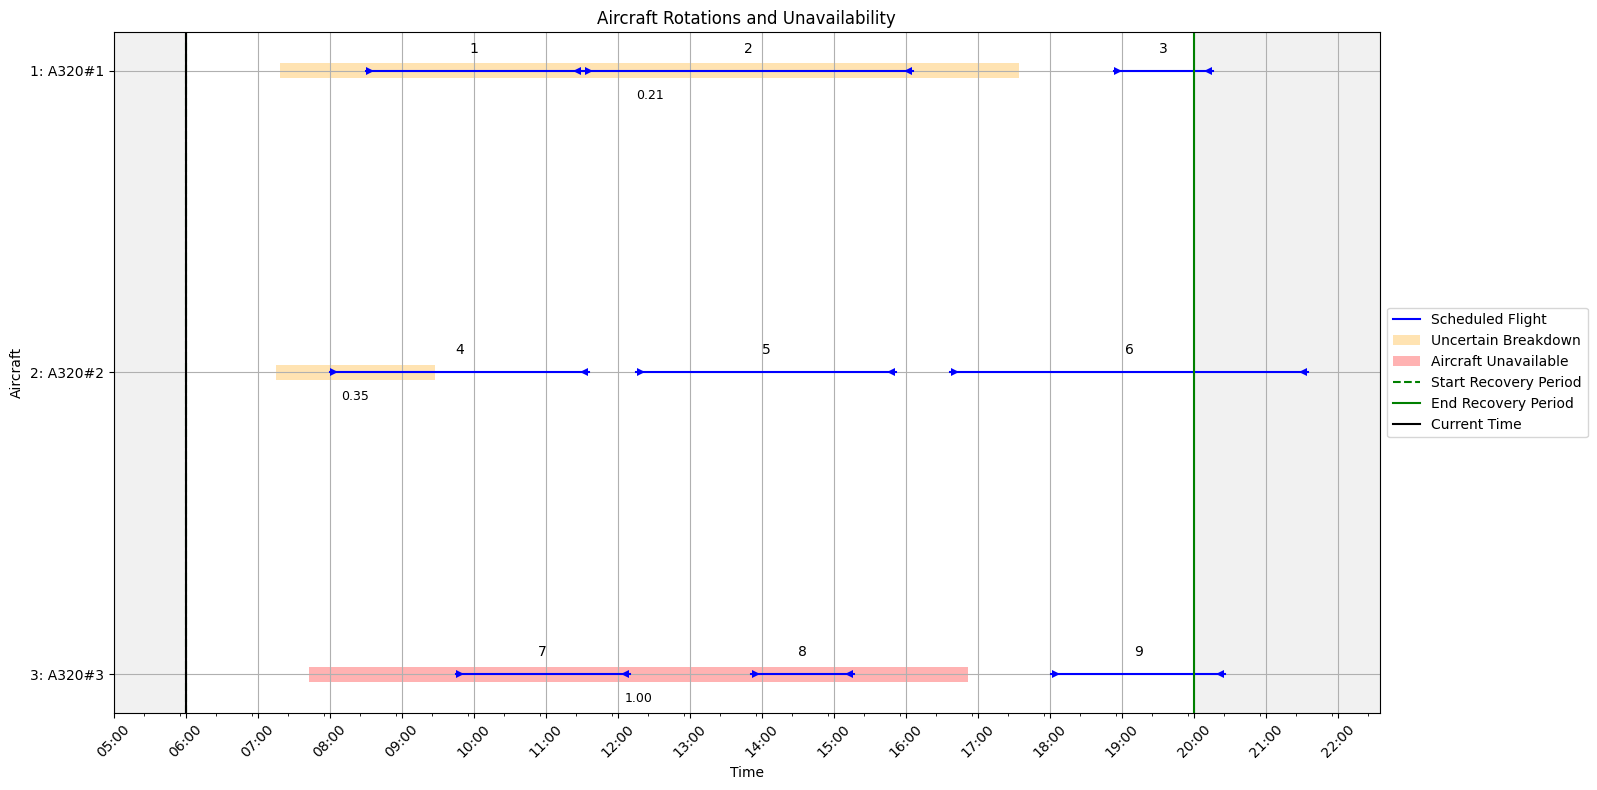

Action taken: (2, 1), Reward: -1000
Step 1:


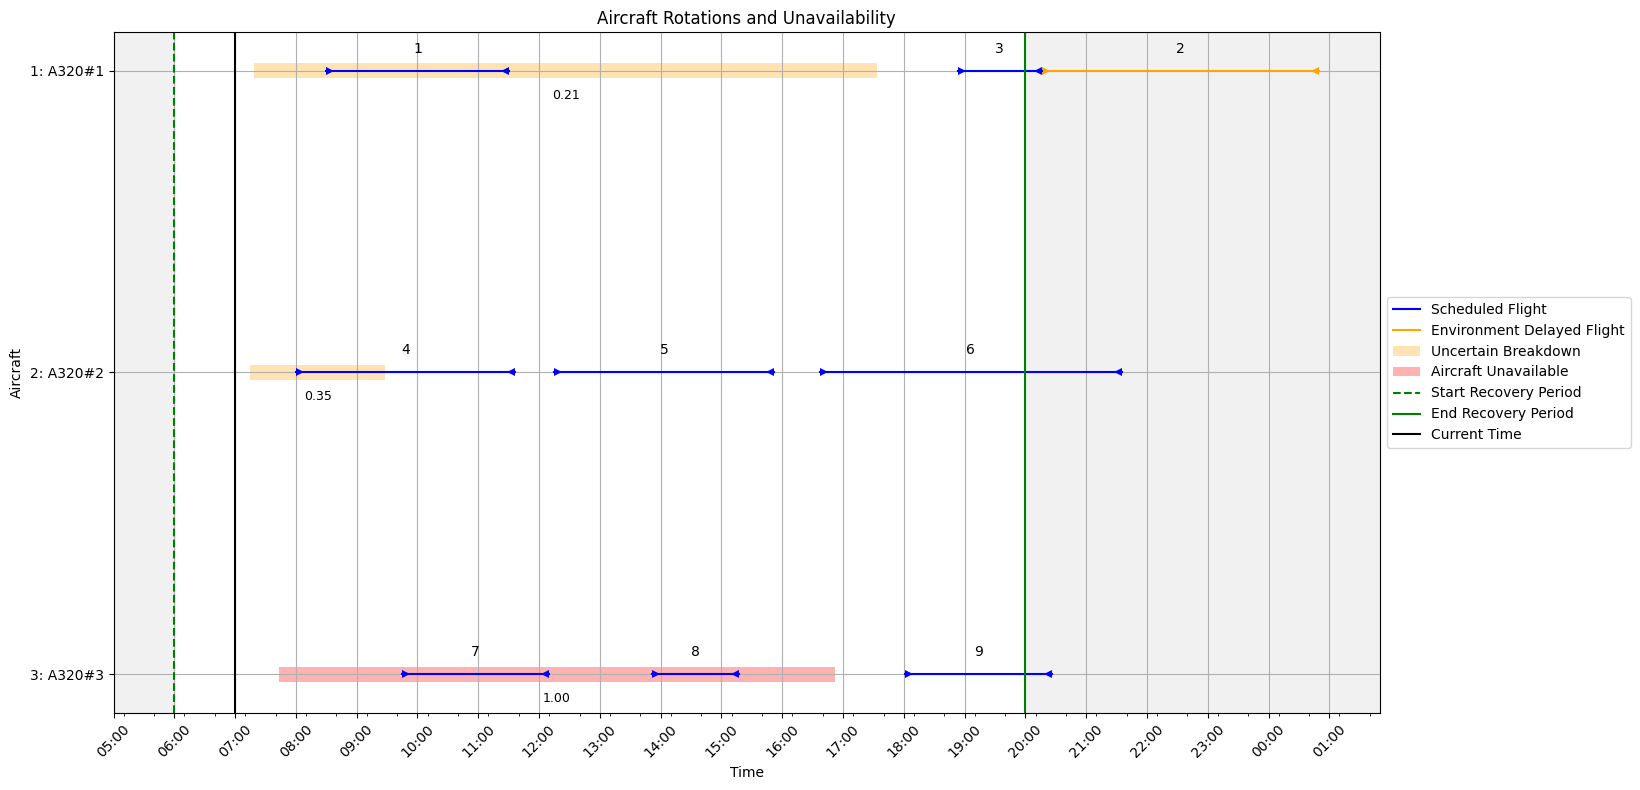

Action taken: (1, 1), Reward: -1000
Step 2:


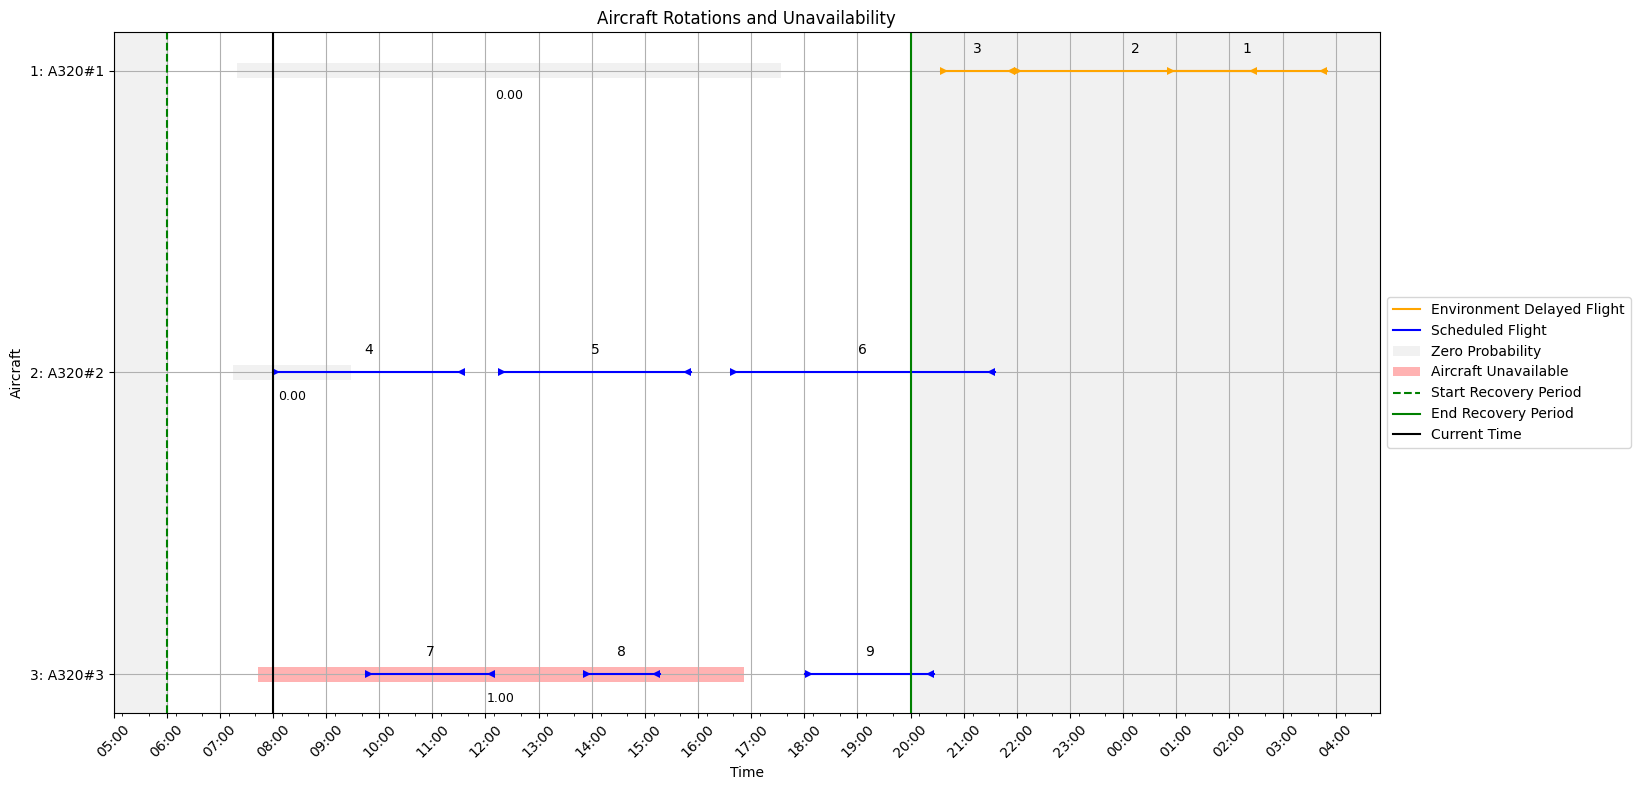

Action taken: (4, 1), Reward: -1000
Step 3:


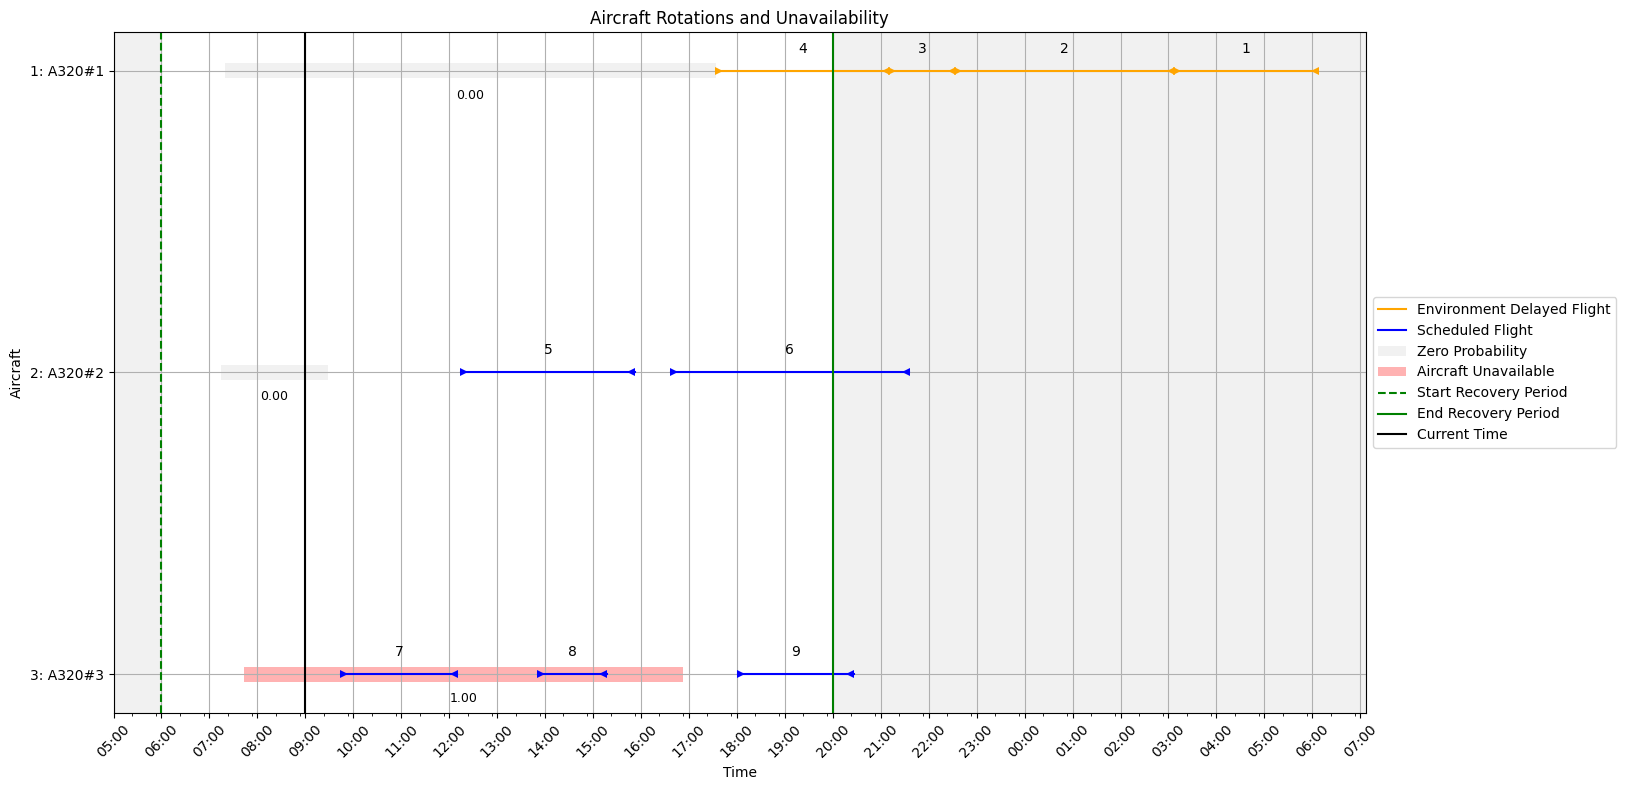

Action taken: (8, 3), Reward: -102.0
Final state:


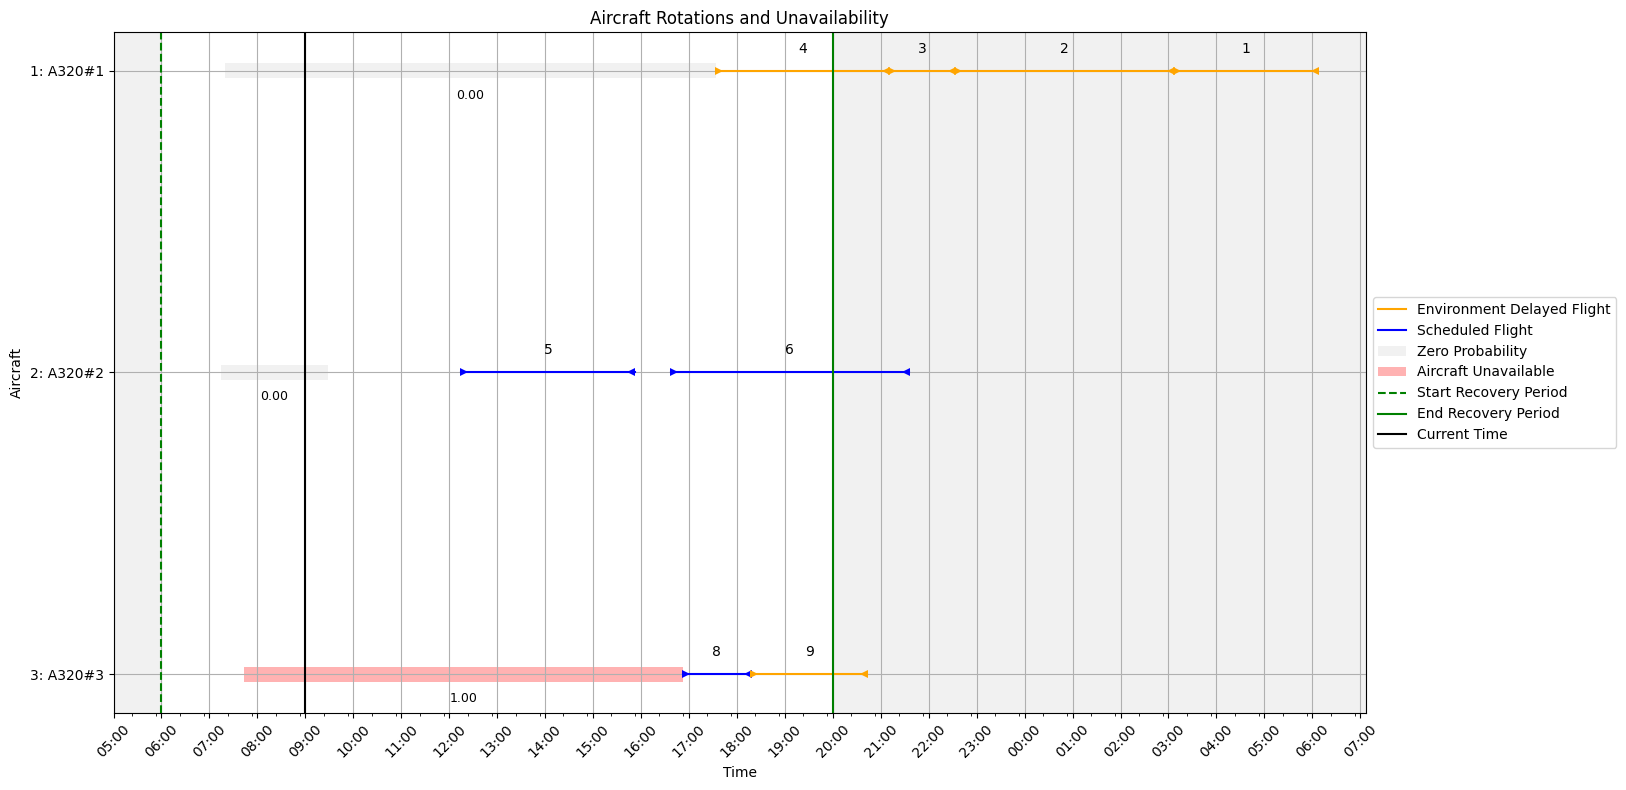

Total Reward: -3102.0
Total Steps: 4


(-3102.0, 4)

In [3]:
import os
import numpy as np
from stable_baselines3 import DQN
from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter
from scripts.utils import load_scenario_data
from src.config import *
import re

# Load the model and run inference
def run_inference_dqn(model_path, scenario_folder, env_type):
    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(
        aircraft_dict, 
        flights_dict, 
        rotations_dict, 
        alt_aircraft_dict, 
        config_dict,
        env_type=env_type
    )

    # Load the trained model and set the environment
    model = DQN.load(model_path)
    model.set_env(env)

    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=env.aircraft_dict,
        flights_dict=env.flights_dict,
        rotations_dict=env.rotations_dict,
        alt_aircraft_dict=env.alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime,
        uncertain_breakdowns=env.uncertain_breakdowns,
    )

    # Reset the environment for inference
    obs, _ = env.reset()
    done_flag = False
    total_reward = 0
    step_num = 0
    max_steps = 1000  # Set a maximum number of steps to prevent infinite loops

    while not done_flag and step_num < max_steps:
        # Visualize the current state
        print(f"Step {step_num}:")

        # Extract necessary information from the environment for plotting
        swapped_flights = env.swapped_flights
        environment_delayed_flights = env.environment_delayed_flights
        current_datetime = env.current_datetime

        # Retrieve the updated dictionaries from the environment
        updated_flights_dict = env.flights_dict
        updated_rotations_dict = env.rotations_dict
        updated_alt_aircraft_dict = env.alt_aircraft_dict
        cancelled_flights = env.penalized_cancelled_flights

        if DEBUG_MODE_VISUALIZATION:
            print("Flights Dict:")
            print(updated_flights_dict)
            print("Alt Aircraft Dict:")
            print(updated_alt_aircraft_dict)
            print("Swapped Flights:")
            print(swapped_flights)
            print("Environment Delayed Flights:")
            print(environment_delayed_flights)
            print("Cancelled Flights:")
            print(cancelled_flights)
            print("Unavailabilities:")
            print(env.alt_aircraft_dict)
            print("Uncertain Breakdowns:")
            for key, value in env.uncertain_breakdowns.items():
                print(f"{key}: {value}")
            print("Current Breakdowns:")
            print(env.current_breakdowns)
            print("")

        # Update the StatePlotter's dictionaries with the updated ones
        state_plotter.alt_aircraft_dict = updated_alt_aircraft_dict
        state_plotter.flights_dict = updated_flights_dict
        state_plotter.rotations_dict = updated_rotations_dict

        # Plot the state using the updated dictionaries
        state_plotter.plot_state(
            updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime
        )

        # Get the action mask from the environment
        action_mask = obs['action_mask']

        # Convert observation to float32
        obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

        # Get the action mask from the observation
        action_mask = obs.get('action_mask', None)
        if action_mask is None:
            raise ValueError("Action mask is missing in the observation!")

        # Get the Q-values and apply the action mask
        obs_tensor = model.policy.obs_to_tensor(obs)[0]
        q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

        # Mask invalid actions by setting their Q-values to -inf
        masked_q_values = q_values.copy()
        masked_q_values[action_mask == 0] = -np.inf

        # Predict the action using the masked Q-values
        action = np.argmax(masked_q_values)

        # Verify if the action is valid
        if action_mask[action] == 0:
            raise ValueError(f"Invalid action selected by the model: {action}")

        # Take action in the environment
        obs, reward, terminated, truncated, info = env.step(action)

        # Accumulate the reward
        total_reward += reward

        action_mapped = env.map_index_to_action(action)
        print(f"Action taken: {action_mapped}, Reward: {reward}")

        # Combine terminated and truncated flags
        done_flag = terminated or truncated

        step_num += 1

    print("================================================")
    print("Final state:")
    # Plot final state
    state_plotter.plot_state(
        updated_flights_dict, 
        swapped_flights, 
        environment_delayed_flights, 
        cancelled_flights, 
        current_datetime
    )

    print(f"Total Reward: {total_reward}")
    print(f"Total Steps: {step_num}")

    return total_reward, step_num

# Specify the model path and the scenario folder
MODEL_PATH = "../trained_models/proactive_1k-3ac-12f-1dis-F-500k-1.zip"
SCENARIO_FOLDER = '../Data/Example/3ac-12f-1dis-F/Scenario_01'

# Extract the env_type using regex
match = re.search(r'/(myopic|proactive)_', MODEL_PATH)
env_type = match.group(1) if match else None

print(f"Environment Type: {env_type}")

# Verify folder and model exist
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

# Run the fixed inference loop
run_inference_dqn(MODEL_PATH, SCENARIO_FOLDER, env_type)
